## Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

c:\Users\YounghoonAhn\anaconda3\envs\gisan\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\YounghoonAhn\anaconda3\envs\gisan\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\YounghoonAhn\anaconda3\envs\gisan\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\YounghoonAhn\anaconda3\envs\gisan\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:572: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  (np.object, string),
c:\Users\YounghoonAhn\anaconda3\envs\gisan\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:572: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  (np.object, string),
c:\Users\YounghoonAhn\anaconda3\envs\gisan\lib\site-packages\numpy\_distributor_init.py:30: UserWarning

## Setup imports

In [1]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch
from torch.nn import DataParallel

print_config()

MONAI version: 1.2.0rc7+1.g8e725aa
Numpy version: 1.23.5
Pytorch version: 1.13.1
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8e725aa2f3c50ffd1c0c45e8917d85f20c6637d0
MONAI __file__: /scratch/x2519a05/.conda/envs/notebook/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.2
pandas version: 1.5.3
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please

## Setup data directory



In [5]:
##change the root_path to your brats21 data
root_dir='/scratch/x2519a05/workspace/BRATS21'
os.chdir(root_dir)
print(root_dir)

/scratch/x2519a05/workspace/BRATS21


## Setup average meter, fold reader, checkpoint saver

In [6]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

## Setup dataloader

In [7]:
(128,)*3

(128, 128, 128)

In [18]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
            # transforms.Resized(keys=["image", "label"], spatial_size=(128,)*3, mode='trilinear') # change due to GPU limit
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.Resized(keys=["image", "label"], spatial_size=(128,)*3, mode='trilinear') # change due to GPU limit
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    return train_loader, val_loader

## Set dataset root directory and hyper-parameters

The following hyper-parameters are set for the purpose of this tutorial. However, additional changes, as described below, maybe beneficial. 

If GPU memory is not sufficient, reduce sw_batch_size to 2 or batch_size to 1. 

Decrease val_every (validation frequency) to 1 for obtaining more accurate checkpoints.

In [19]:
data_dir = '/scratch/x2519a05/data/BraTS2021/'
json_list = "./jsons/brats21_folds.json"
roi = (128, 128, 128)
batch_size = 1
sw_batch_size = 1
fold = 1
infer_overlap = 0.5
max_epochs = 100
val_every = 10
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

## Check data shape and visualize

image shape: (240, 240, 155), label shape: (240, 240, 155)


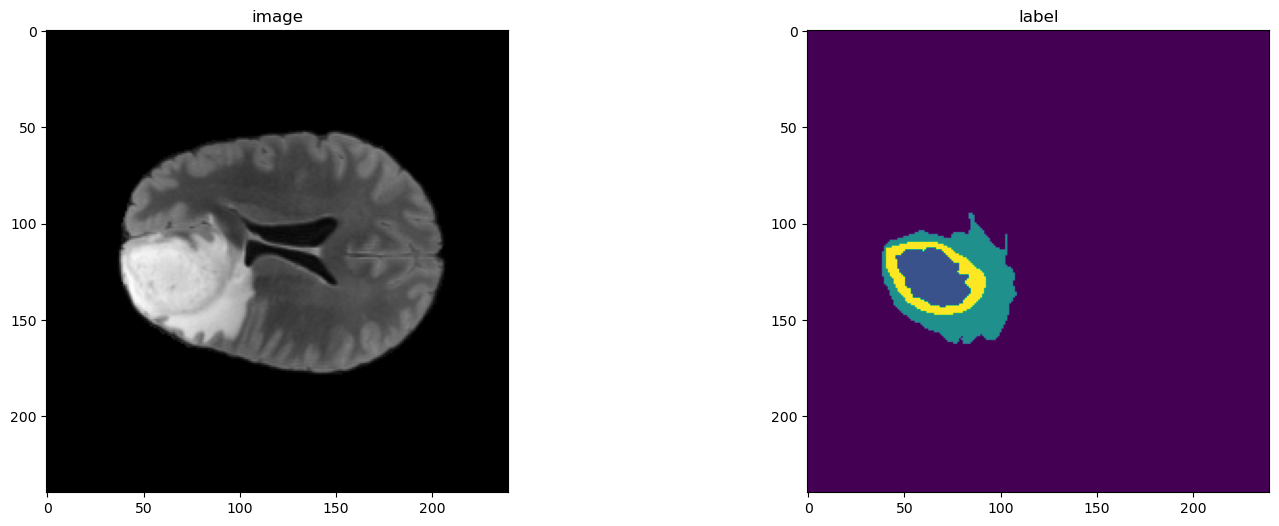

In [20]:
img_add = os.path.join(data_dir, "TrainingData/BraTS2021_00006/BraTS2021_00006_flair.nii.gz")
label_add = os.path.join(data_dir, "TrainingData/BraTS2021_00006/BraTS2021_00006_seg.nii.gz")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

## Create Swin UNETR model

In this scetion, we create Swin UNETR model for the 3-class brain tumor semantic segmentation. We use a feature size of 48. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training. However, use_checkpoint for faster training if enough GPU memory is available.  

In [22]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
)
model.load_state_dict(torch.load('./pretrained_models/model_fold1.pt')['state_dict'])
model = DataParallel(model).to(device)

## Optimizer and loss function

In [23]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

## Define Train and Validation Epoch

In [24]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(data)
            loss = loss_func(logits, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

## Define Trainer

In [25]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

## Add CRF module

- Original workflow
    - img(Batch x Modality x H x W x D) => model => logits(Batch x N of Tumor type x H x W x D) => Sigmoid(voxel-wise probability for each tumor type) => DICE Loss

- Proposed workflow using CRF
    - img(Batch x Modality x H x W x D) => model => logits(Batch x N of Tumor type x H x W x D) => CRF => Voxel-wise probability for each tumor type) => DICE Loss


In [26]:
import monai

In [27]:
crf_block = monai.networks.blocks.CRF().cuda()

In [30]:
model.eval()
None

In [31]:
for idx, batch_data in enumerate(val_loader):
    img, target = batch_data["image"].to(device), batch_data["label"].to(device)
    break

In [34]:
dice_loss_wosigmoid = DiceLoss(to_onehot_y=False, sigmoid=False)

In [35]:
# with torch.autocast(device_type='cuda', dtype=torch.float16):
logits = model(img)
loss = dice_loss(logits, target)
orig_loss = loss.item()
crf_loss = dice_loss_wosigmoid(crf_block(logits, target), target).item()

In [36]:
crf_loss_sigm = dice_loss_wosigmoid(crf_block(torch.sigmoid(logits),target), target).item()

In [37]:
orig_loss, crf_loss, crf_loss_sigm

(0.18509799242019653, 0.7898115515708923, 0.9730970859527588)

In [38]:
prob = torch.sigmoid(logits.detach().cpu())
seg = prob[0].detach().cpu().numpy()
seg = (seg > 0.5).astype(np.int8)
seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
seg_out[seg[1] == 1] = 2
seg_out[seg[0] == 1] = 1
seg_out[seg[2] == 1] = 4

In [39]:
from nilearn import plotting     

In [83]:
img.affine.numpy().squeeze(), img.affine.numpy().squeeze()*[1,1,1,1/2]*[[1],[1],[1],[2]]

(array([[ -1.,   0.,   0., -43.],
        [  0.,   1.,   0.,  33.],
        [  0.,   0.,  -1., 198.],
        [  0.,   0.,   0.,   1.]]),
 array([[ -1. ,   0. ,   0. , -21.5],
        [  0. ,   1. ,   0. ,  16.5],
        [  0. ,   0. ,  -1. ,  99. ],
        [  0. ,   0. ,   0. ,   1. ]]))

In [84]:
niftiimg = nib.Nifti1Image(img[:,1,:].squeeze().cpu().numpy(), affine=img.affine.numpy().squeeze()*[1,1,1,1/2]*[[1],[1],[1],[2]])

/scratch/x2519a05/.conda/envs/notebook/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '
/scratch/x2519a05/.conda/envs/notebook/lib/python3.10/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



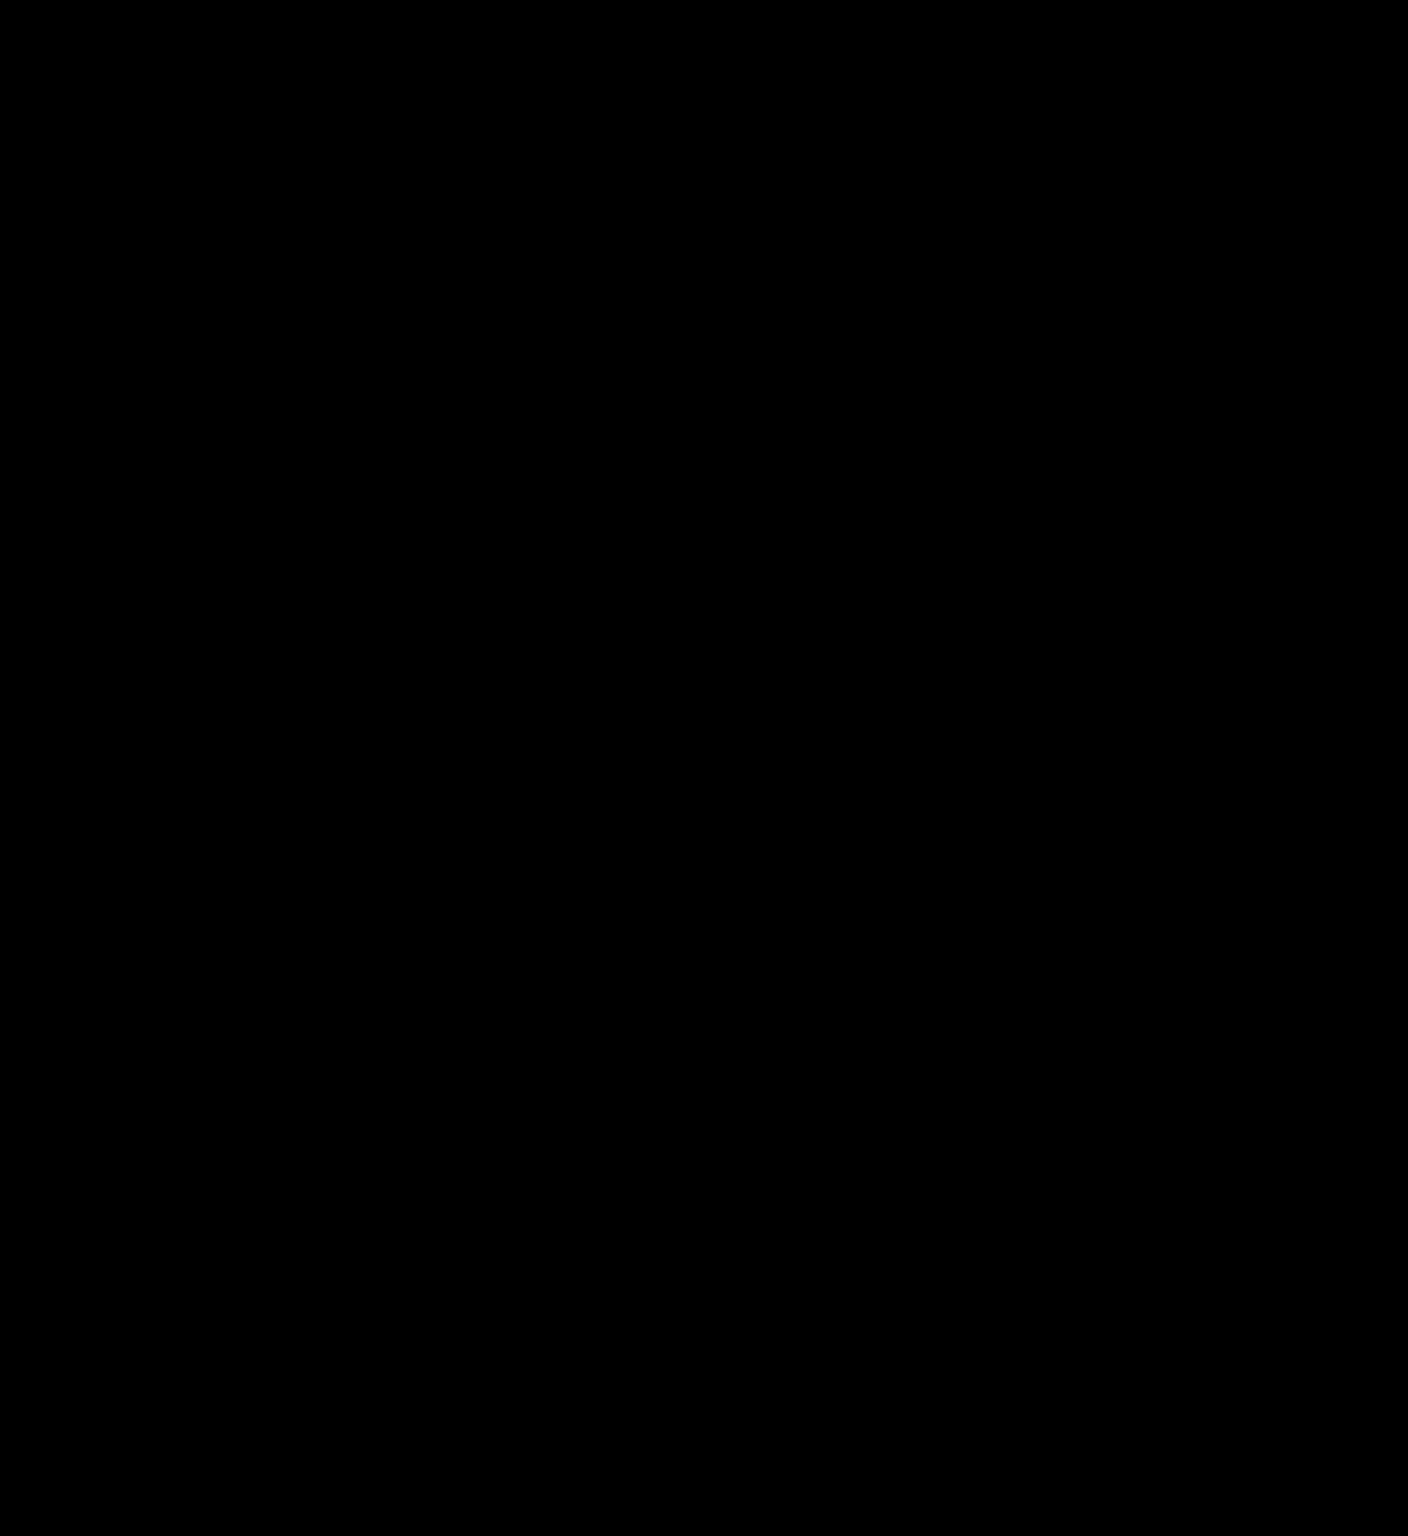
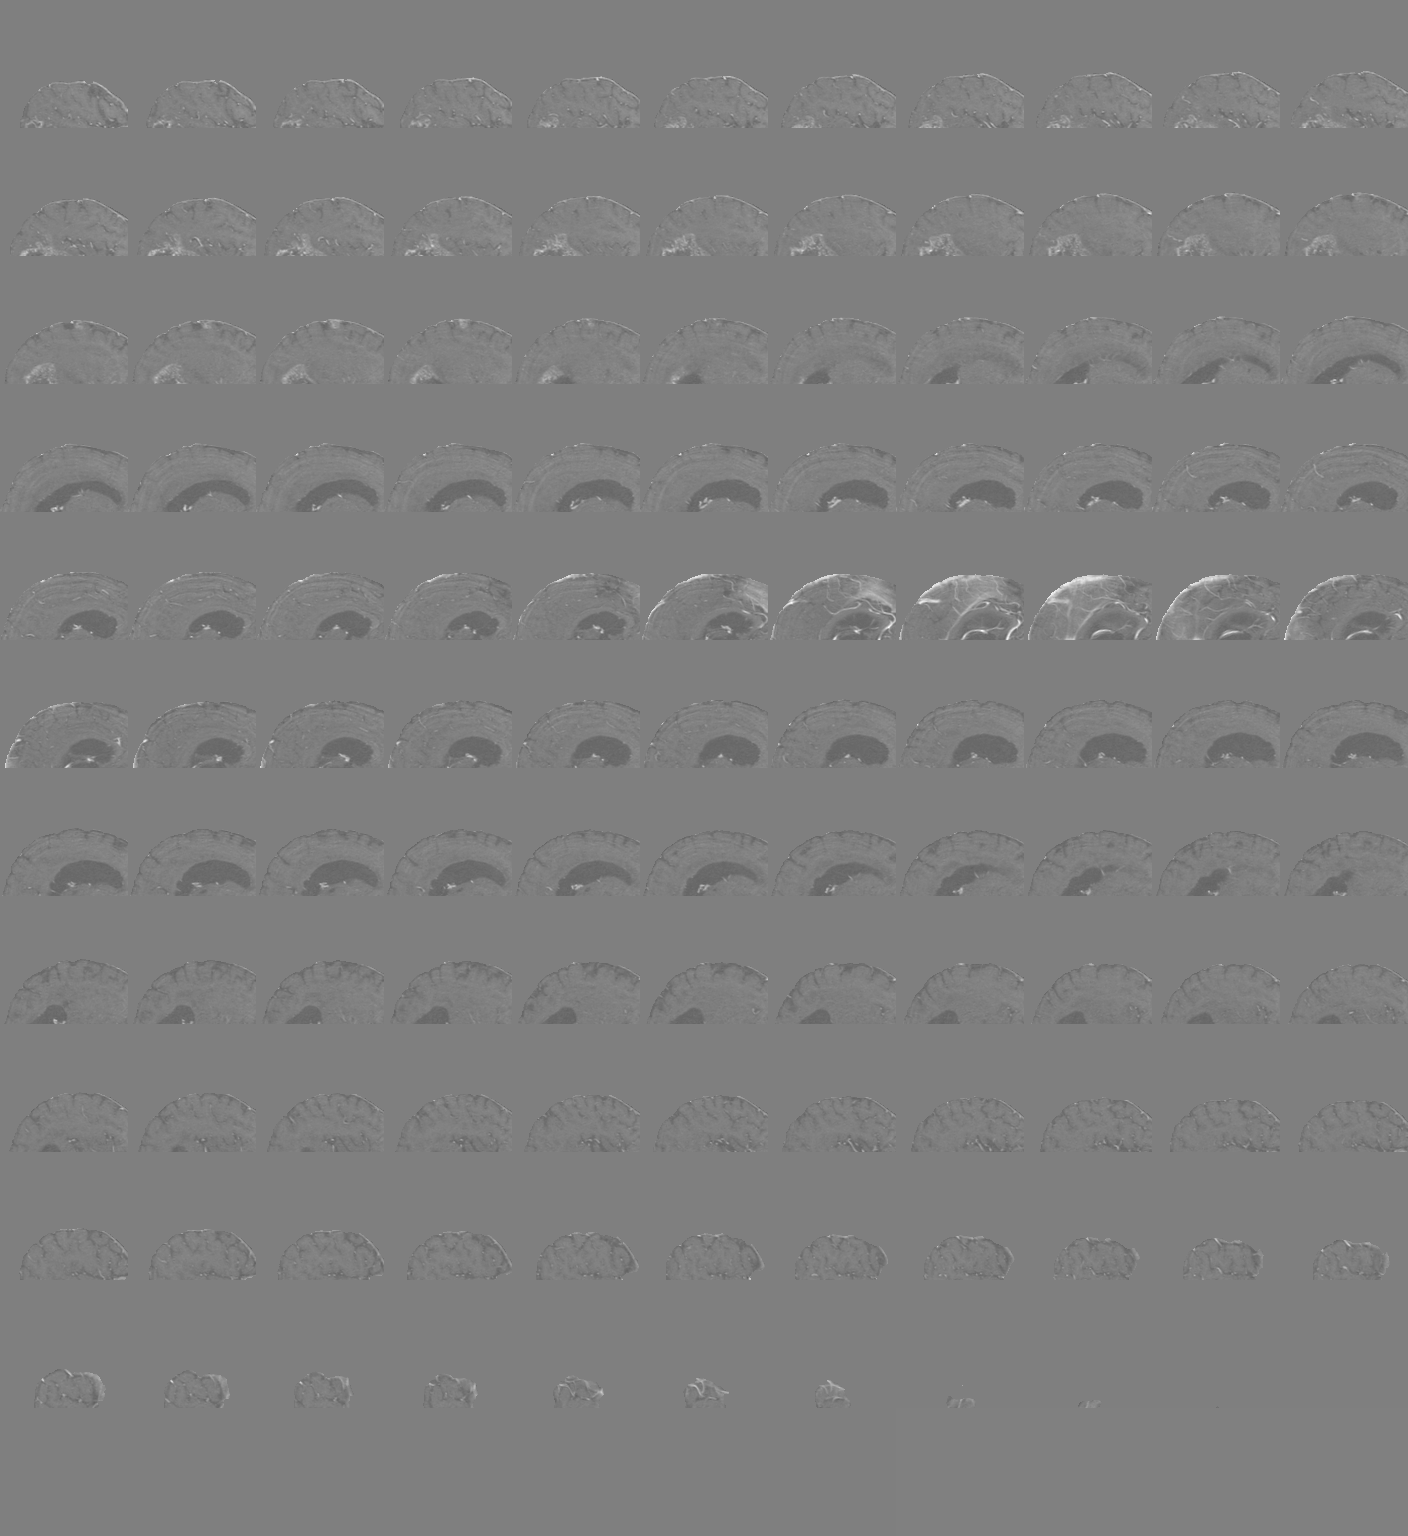

In [101]:
html_view = plotting.view_img(niftiimg, title=f"original image", bg_img=False, black_bg=True, threshold=None, cmap='gray', symmetric_cmap=False)
html_view.resize(1000,500)

In [98]:
nifti_crf = nib.Nifti1Image(after_crf[:,1,:].squeeze().cpu().numpy(), affine=img.affine.numpy().squeeze()*[1,1,1,1/2]*[[1],[1],[1],[2]])

/scratch/x2519a05/.conda/envs/notebook/lib/python3.10/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



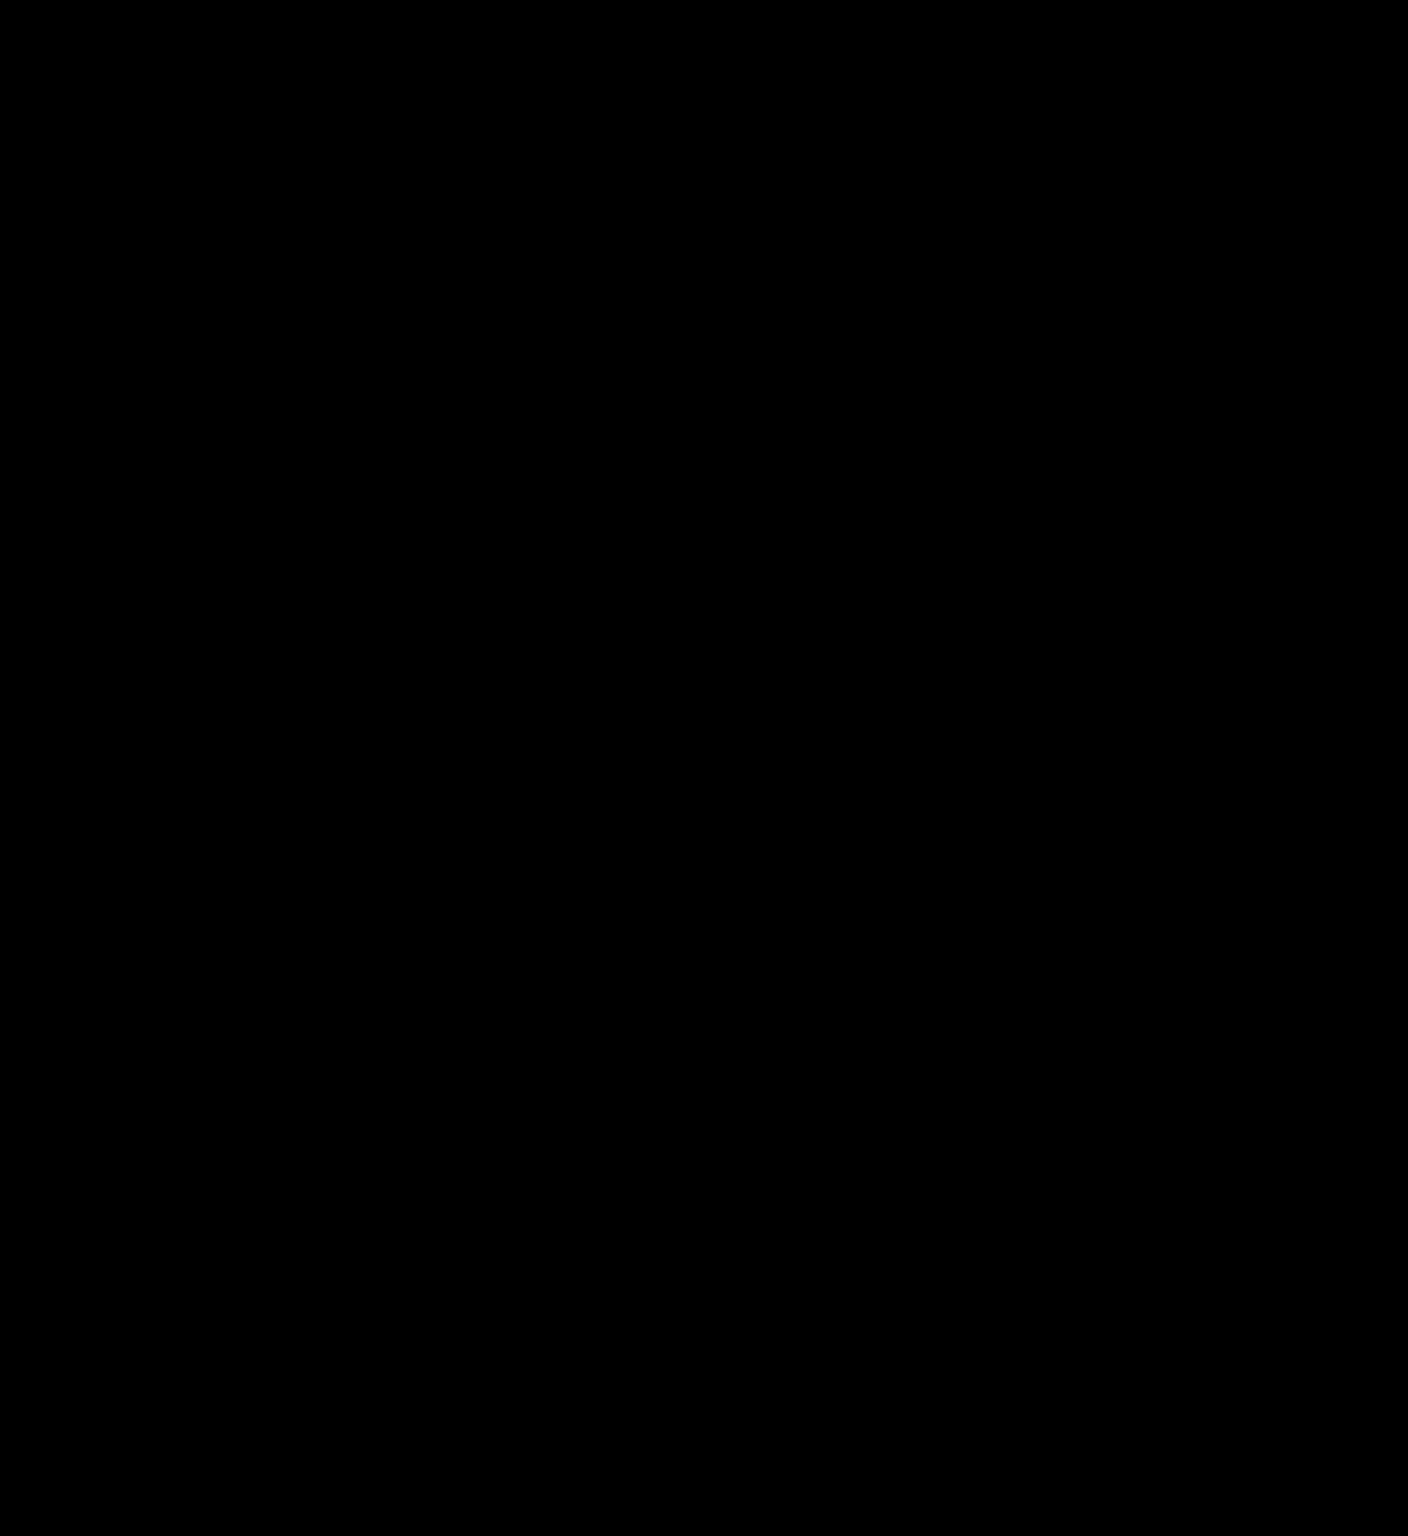
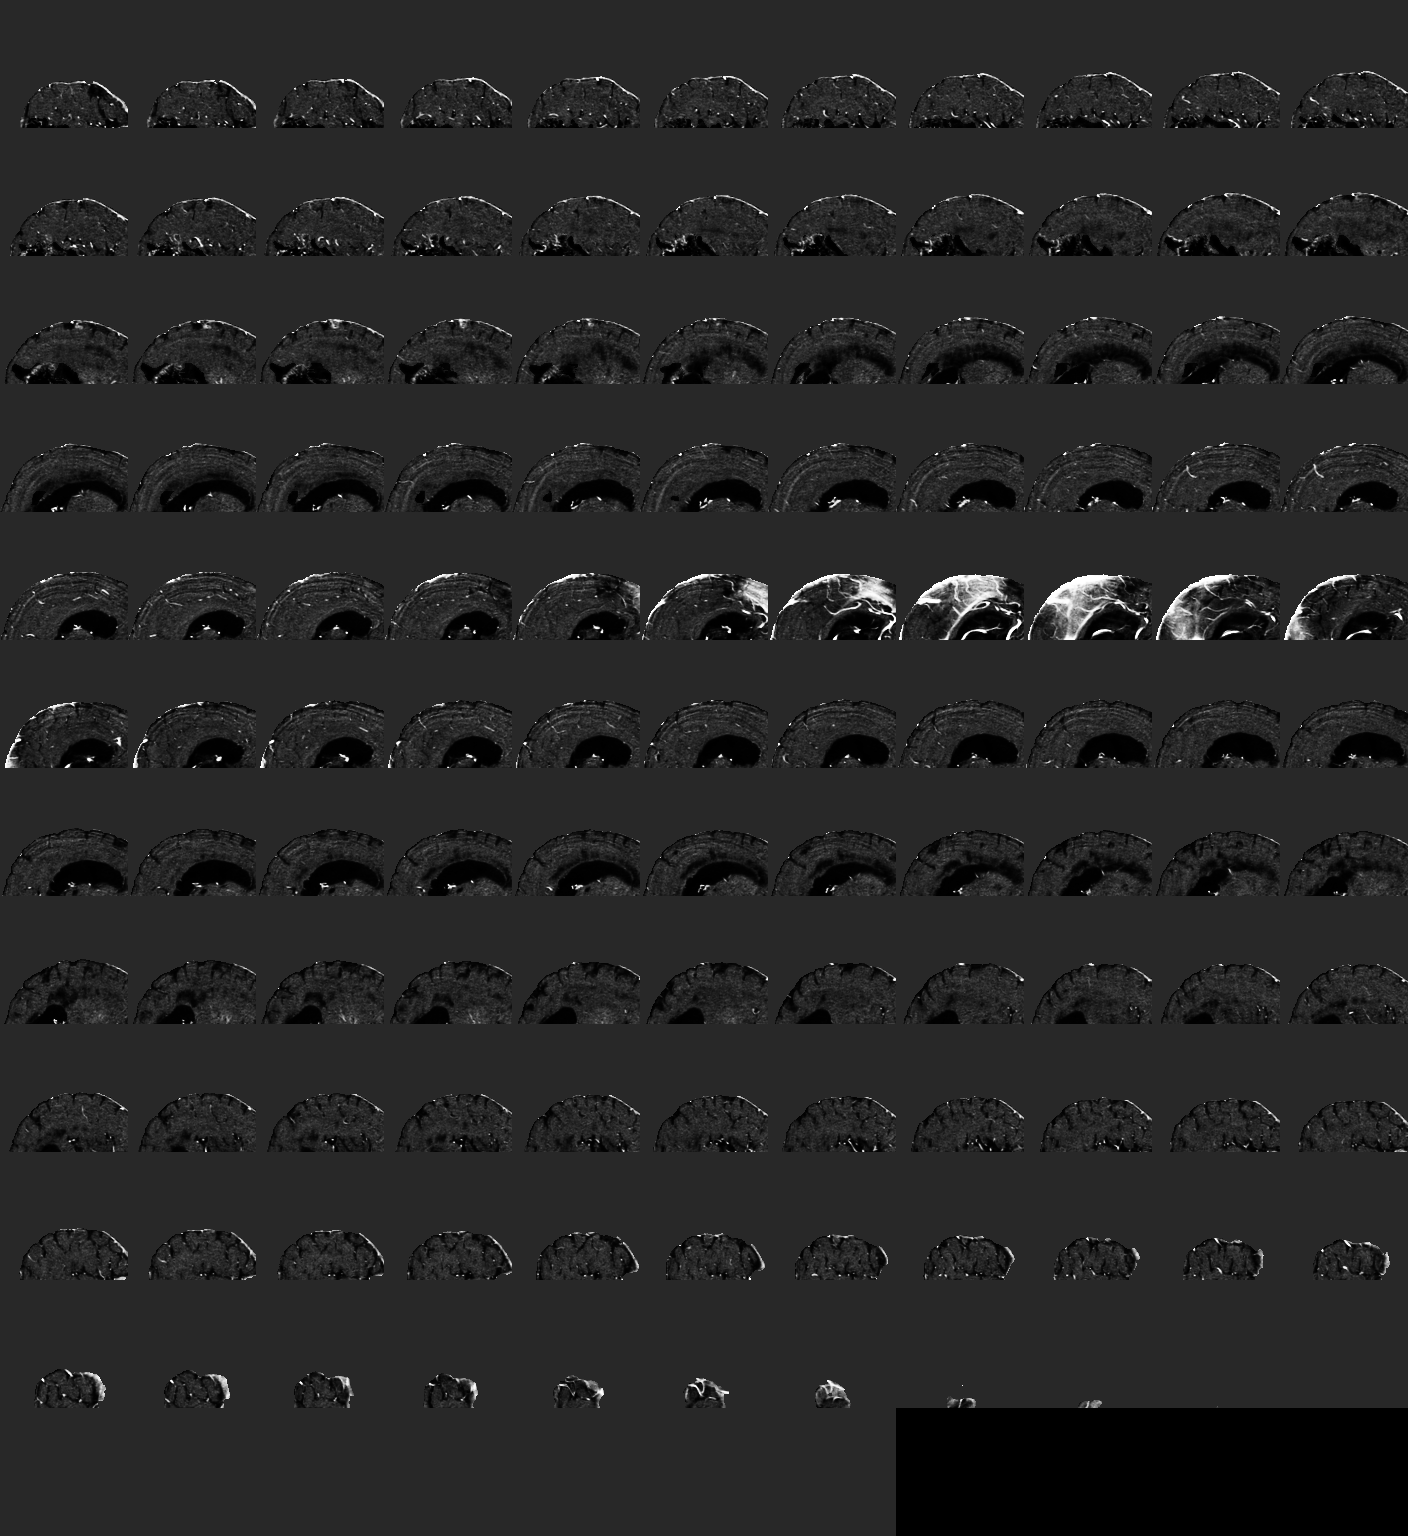

In [100]:
html_view = plotting.view_img(nifti_crf, title=f"after crf image", bg_img=False, black_bg=True, threshold=None, cmap='gray',  symmetric_cmap=False)
html_view.resize(1000,500)

### compare result

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import nibabel as nib

%matplotlib inline

def plot_brain(img, s, h, c):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,12))
    shapes = img.shape
    
    axes[0].imshow(img[s,:,:], cmap='gray')
    axes[0].set_title('Sagittal view')
    axes[0].set_axis_off()

    axes[1].imshow(np.rot90(img[:,h,:],-1), cmap='gray')
    axes[1].set_title('Horizontal view')
    axes[1].set_axis_off()

    axes[2].imshow(np.rot90(img[:,:,c],-1), cmap='gray')
    axes[2].set_title('Coronal view')
    axes[2].set_axis_off()    
    plt.show()

In [43]:
img.min()

metatensor(-3.3545, device='cuda:0')

In [41]:
npimg = img[:,1,:].squeeze().cpu().numpy()
center = list(map(lambda x: x//2, npimg.shape))
slider=(0,npimg.shape[0],1)
# plot_brain(img, *center)
# interact(plot_brain, img=fixed(npimg), s=center[0], h=center[1], c=center[2])
interact(plot_brain, img=fixed(npimg), s=slider, h=slider, c=slider)

interactive(children=(IntSlider(value=64, description='s', max=128), IntSlider(value=64, description='h', max=…

<function __main__.plot_brain(img, s, h, c)>

In [47]:
target.min(), target.max()

(metatensor(0., device='cuda:0'), metatensor(1., device='cuda:0'))

In [50]:
nptarget = target[:,1,:].squeeze().cpu().numpy()
center = list(map(lambda x: x//2, nptarget.shape))
slider=(0,npimg.shape[0],1)
# plot_brain(img, *center)
# interact(plot_brain, img=fixed(npimg), s=center[0], h=center[1], c=center[2])
interact(plot_brain, img=fixed(nptarget), s=slider, h=slider, c=slider)

interactive(children=(IntSlider(value=64, description='s', max=128), IntSlider(value=64, description='h', max=…

<function __main__.plot_brain(img, s, h, c)>

In [133]:
npout.max()

66.75

In [51]:
npout = torch.sigmoid(logits[:,1,:]).squeeze().detach().cpu().numpy()
center = list(map(lambda x: x//2, npout.shape))
slider=(0,npimg.shape[0],1)
# plot_brain(img, *center)
# interact(plot_brain, img=fixed(npimg), s=center[0], h=center[1], c=center[2])
interact(plot_brain, img=fixed(npout), s=slider, h=slider, c=slider)

interactive(children=(IntSlider(value=64, description='s', max=128), IntSlider(value=64, description='h', max=…

<function __main__.plot_brain(img, s, h, c)>

In [55]:
npout_crf.min()

3.9151333e-22

In [56]:
npout_crf = crf_block(torch.sigmoid(logits), target)[:,1,:].squeeze().detach().cpu().numpy()
center = list(map(lambda x: x//2, npout_crf.shape))
slider=(0,npimg.shape[0],1)
# plot_brain(img, *center)
# interact(plot_brain, img=fixed(npimg), s=center[0], h=center[1], c=center[2])
interact(plot_brain, img=fixed(npout_crf), s=slider, h=slider, c=slider)

interactive(children=(IntSlider(value=64, description='s', max=128), IntSlider(value=64, description='h', max=…

<function __main__.plot_brain(img, s, h, c)>

In [149]:
center = list(map(lambda x: x//2, seg_out.shape))
slider=(0,seg_out.shape[0],1)
# plot_brain(img, *center)
# interact(plot_brain, img=fixed(npimg), s=center[0], h=center[1], c=center[2])
interact(plot_brain, img=fixed(seg_out), s=slider, h=slider, c=slider)

interactive(children=(IntSlider(value=64, description='s', max=128), IntSlider(value=64, description='h', max=…

<function __main__.plot_brain(img, s, h, c)>

In [152]:
sig_crf=torch.sigmoid(after_crf)
sig_crf.min(),after_crf.min(), sig_crf.max(), after_crf.max()

(metatensor(0.5000, device='cuda:0'),
 metatensor(1.5633e-06, device='cuda:0'),
 metatensor(0.7311, device='cuda:0'),
 metatensor(1.0000, device='cuda:0'))

In [156]:
sig_crf.sum(), after_crf.sum()

(metatensor(4712649., device='cuda:0'),
 metatensor(2097151.8750, device='cuda:0'))

In [159]:
prob.min()

tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>)

In [165]:
after_crf.shape

torch.Size([1, 4, 128, 128, 128])

In [ ]:
crf_seg = prob[0].detach().cpu().numpy()
crf_seg = (seg > 0.5).astype(np.int8)
crf_seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
crf_seg_out[seg[1] == 1] = 2
crf_seg_out[seg[0] == 1] = 1
crf_seg_out[seg[2] == 1] = 4

In [ ]:
# uninstall monai and execute below code if getting ImportError about "monai._C"
# BUILD_MONAI=1 pip install --no-build-isolation git+https://github.com/Project-MONAI/MONAI#egg=monai

  Cloning https://github.com/Project-MONAI/MONAI to /tmp/pip-install-qzgdn8aq/monai_ae062af58369423e9af268e89fc04053
  Running command git clone --quiet https://github.com/Project-MONAI/MONAI /tmp/pip-install-qzgdn8aq/monai_ae062af58369423e9af268e89fc04053
  Resolved https://github.com/Project-MONAI/MONAI to commit e084885c6d498ab02df8107d23aa159f742a2cdd
  Installing build dependencies ... /

## Execute training

In [ ]:
start_epoch = 0

(
    val_acc_max,
    dices_tc,
    dices_wt,
    dices_et,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Tue May 16 17:06:38 2023 Epoch: 0
Epoch 0/100 0/1001 loss: 0.9719 time 29.79s
Epoch 0/100 1/1001 loss: 0.9757 time 0.69s
Epoch 0/100 2/1001 loss: 0.9727 time 0.70s
Epoch 0/100 3/1001 loss: 0.9698 time 0.63s
Epoch 0/100 4/1001 loss: 0.9759 time 0.61s
Epoch 0/100 5/1001 loss: 0.9513 time 1.73s
Epoch 0/100 6/1001 loss: 0.9579 time 0.93s
Epoch 0/100 7/1001 loss: 0.9631 time 1.98s
Epoch 0/100 8/1001 loss: 0.9638 time 0.95s
Epoch 0/100 9/1001 loss: 0.9632 time 1.62s
Epoch 0/100 10/1001 loss: 0.9657 time 1.31s
Epoch 0/100 11/1001 loss: 0.9660 time 2.17s
Epoch 0/100 12/1001 loss: 0.9626 time 0.86s
Epoch 0/100 13/1001 loss: 0.9652 time 2.05s
Epoch 0/100 14/1001 loss: 0.9605 time 0.92s
Epoch 0/100 15/1001 loss: 0.9608 time 1.92s
Epoch 0/100 16/1001 loss: 0.9631 time 0.62s
Epoch 0/100 17/1001 loss: 0.9644 time 3.12s
Epoch 0/100 18/1001 loss: 0.9618 time 0.64s
Epoch 0/100 19/1001 loss: 0.9636 time 2.17s
Epoch 0/100 20/1001 loss: 0.9640 time 0.66s
Epoch 0/100 21/1001 loss: 0.9646 time 2.06s
Epoch 0

/scratch/x2519a05/.conda/envs/notebook/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Val 0/100 0/250 , dice_tc: 0.21256848 , dice_wt: 0.91244346 , dice_et: 0.7070308 , time 5.64s
Val 0/100 1/250 , dice_tc: 0.4630674 , dice_wt: 0.9277827 , dice_et: 0.7487836 , time 0.36s
Val 0/100 2/250 , dice_tc: 0.47215235 , dice_wt: 0.92190653 , dice_et: 0.76744026 , time 0.32s
Val 0/100 3/250 , dice_tc: 0.55470526 , dice_wt: 0.92177033 , dice_et: 0.7839314 , time 0.50s
Val 0/100 4/250 , dice_tc: 0.46728334 , dice_wt: 0.8271187 , dice_et: 0.75996524 , time 2.65s
Val 0/100 5/250 , dice_tc: 0.48723242 , dice_wt: 0.844413 , dice_et: 0.7806532 , time 0.32s
Val 0/100 6/250 , dice_tc: 0.4252604 , dice_wt: 0.7974577 , dice_et: 0.714125 , time 2.33s
Val 0/100 7/250 , dice_tc: 0.3855711 , dice_wt: 0.80423445 , dice_et: 0.6822865 , time 0.34s
Val 0/100 8/250 , dice_tc: 0.4281084 , dice_wt: 0.80982906 , dice_et: 0.7105762 , time 2.56s
Val 0/100 9/250 , dice_tc: 0.4013567 , dice_wt: 0.82207805 , dice_et: 0.7213648 , time 0.90s
Val 0/100 10/250 , dice_tc: 0.40597335 , dice_wt: 0.7981907 , dice_et

In [ ]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")

### Plot the loss and Dice metric

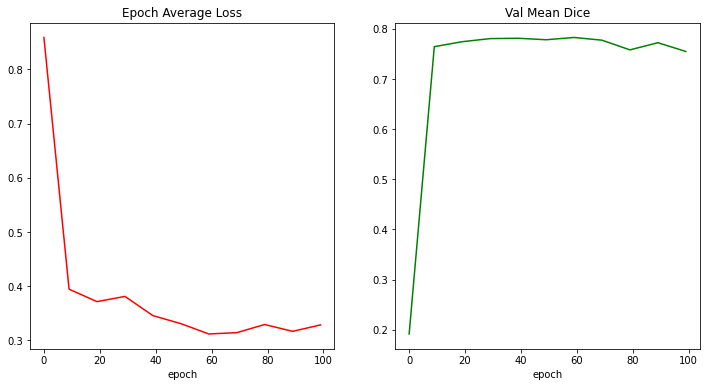

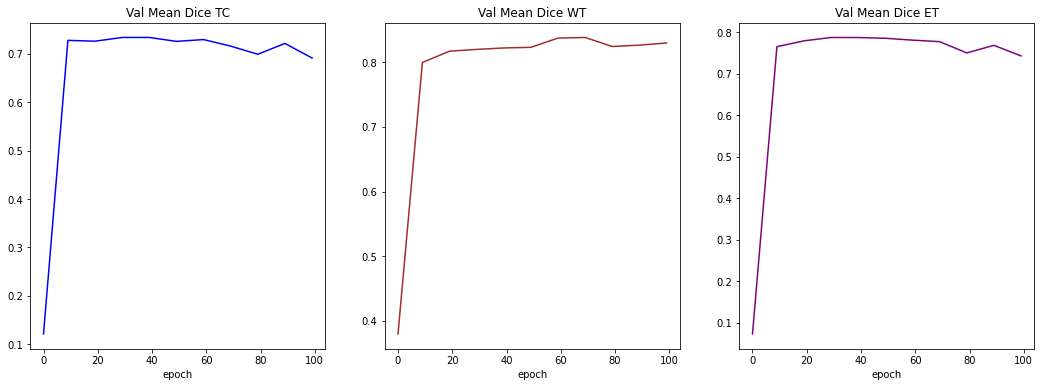

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tc, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_wt, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_et, color="purple")
plt.show()

## Create test set dataloader

In [ ]:
case_num = "01619"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t2.nii.gz",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

## Load the best saved checkpoint and perform inference 

We select a single case from the validation set and perform inference to compare the model segmentation output with the corresponding label. 

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "model.pt"))["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

## Visualize segmentation output and compare with label

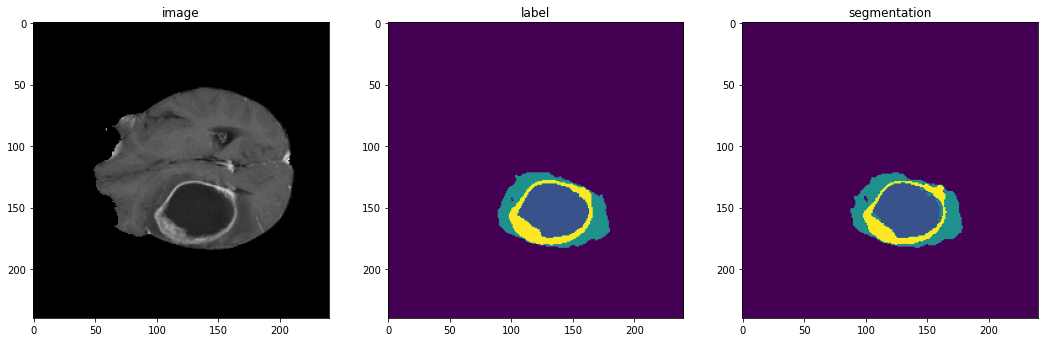

In [ ]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
)
label_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)